In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import urllib.request
import matplotlib.pyplot as plt
import tensorflow as tf

import cv2
from sklearn.model_selection import train_test_split

from keras.datasets import cifar10
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Activation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
(X_train, y_train_single), (X_test, y_test_single) = cifar10.load_data()

X_train, X_valid, y_train_single, y_valid_single = train_test_split(X_train, y_train_single, test_size=0.1, random_state=0)

print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train_single.shape)

print('\nValidation Images Shape: ', X_valid.shape)
print('Validation Labels Shape: ', y_valid_single.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test_single.shape)

X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')

mean = np.mean(X_train, axis=(0, 1, 2, 3))
std = np.std(X_train, axis=(0, 1, 2, 3))

X_train = (X_train - mean) / (std + 1e-7)
X_valid = (X_valid - mean) / (std + 1e-7)
X_test = (X_test - mean) / (std + 1e-7)

y_train_cat = to_categorical(y_train_single, 10)
y_valid_cat = to_categorical(y_valid_single, 10)
y_test_cat = to_categorical(y_test_single, 10)

y_train = [y_train_cat, y_train_cat, y_train_cat, y_train_cat]
y_valid = [y_valid_cat, y_valid_cat, y_valid_cat, y_valid_cat]
y_test = [y_test_cat, y_test_cat, y_test_cat, y_test_cat]

data_generator = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.1,
    zoom_range=0.1
)

data_generator.fit(X_train)

Train Images Shape:       (45000, 32, 32, 3)
Train Labels Shape:       (45000, 1)

Validation Images Shape:  (5000, 32, 32, 3)
Validation Labels Shape:  (5000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


In [3]:
def create_early_exit_cnn_model(input_shape, num_classes=10):
    weight_decay = 0.0001
    
    inputs = Input(shape=input_shape)
    x = inputs
    outputs = []
    
    x = Conv2D(filters=32, kernel_size=(3,3), padding='same', kernel_regularizer=l2(weight_decay), name='conv1_1')(x)
    x = BatchNormalization(name='bn1_1')(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=32, kernel_size=(3,3), padding='same', kernel_regularizer=l2(weight_decay), name='conv1_2')(x)
    x = BatchNormalization(name='bn1_2')(x)
    x = Activation('relu')(x)
    pool1 = MaxPooling2D(pool_size=(2, 2), name='pool1')(x)
    x = Dropout(rate=0.2, name='drop1')(pool1)
    
    exit1 = Flatten(name='flatten1')(pool1)
    exit1 = Dense(num_classes, activation='softmax', name='output_exit_1')(exit1)
    outputs.append(exit1)
    
    x = Conv2D(filters=64, kernel_size=(3,3), padding='same', kernel_regularizer=l2(weight_decay), name='conv2_1')(x)   
    x = BatchNormalization(name='bn2_1')(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=64, kernel_size=(3,3), padding='same', kernel_regularizer=l2(weight_decay), name='conv2_2')(x)
    x = BatchNormalization(name='bn2_2')(x)
    x = Activation('relu')(x)
    pool2 = MaxPooling2D(pool_size=(2, 2), name='pool2')(x)
    x = Dropout(rate=0.3, name='drop2')(pool2)
    
    exit2 = Flatten(name='flatten2')(pool2)
    exit2 = Dense(num_classes, activation='softmax', name='output_exit_2')(exit2)
    outputs.append(exit2)
    
    x = Conv2D(filters=128, kernel_size=(3,3), padding='same', kernel_regularizer=l2(weight_decay), name='conv3_1')(x) 
    x = BatchNormalization(name='bn3_1')(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=128, kernel_size=(3,3), padding='same', kernel_regularizer=l2(weight_decay), name='conv3_2')(x)
    x = BatchNormalization(name='bn3_2')(x)
    x = Activation('relu')(x)
    pool3 = MaxPooling2D(pool_size=(2, 2), name='pool3')(x)
    x = Dropout(rate=0.4, name='drop3')(pool3)
    
    exit3 = Flatten(name='flatten3')(pool3)
    exit3 = Dense(num_classes, activation='softmax', name='output_exit_3')(exit3)
    outputs.append(exit3)
    
    x = Conv2D(filters=256, kernel_size=(3,3), padding='same', kernel_regularizer=l2(weight_decay), name='conv4_1')(x) 
    x = BatchNormalization(name='bn4_1')(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=256, kernel_size=(3,3), padding='same', kernel_regularizer=l2(weight_decay), name='conv4_2')(x)
    x = BatchNormalization(name='bn4_2')(x)
    x = Activation('relu')(x)
    pool4 = MaxPooling2D(pool_size=(2, 2), name='pool4')(x)
    x = Dropout(rate=0.5, name='drop4')(pool4)

    x = Flatten(name='flatten4')(x)
    main_output = Dense(num_classes, activation='softmax', name='output_main')(x)
    outputs.append(main_output)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = create_early_exit_cnn_model(X_train.shape[1:])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_1 (Conv2D)    │ (None, 32, 32,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1_1               │ (None, 32, 32,    │        128 │ conv1_1[0][0]     │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ bn1_1[0][0]       │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_2 (Conv2D)    │ (None, 32, 32,    │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1_2               │ (None, 32, 32,    │        128 │ conv1_2[0][0]     │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ bn1_2[0][0]       │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 16, 16,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop1 (Dropout)     │ (None, 16, 16,    │          0 │ pool1[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1 (Conv2D)    │ (None, 16, 16,    │     18,496 │ drop1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2_1               │ (None, 16, 16,    │        256 │ conv2_1[0][0]     │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 16, 16,    │          0 │ bn2_1[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_2 (Conv2D)    │ (None, 16, 16,    │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2_2               │ (None, 16, 16,    │        256 │ conv2_2[0][0]     │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 16, 16,    │          0 │ bn2_2[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 8, 8, 64)  │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop2 (Dropout)     │ (None, 8, 8, 64)  │          0 │ pool2[0][0]     

 Total params: 1,329,736 (5.07 MB)

 Trainable params: 1,327,816 (5.07 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [4]:
batch_size = 64
epochs = 300

optimizer = Adam(learning_rate=0.0005)

loss = ['categorical_crossentropy'] * 4
loss_weights = [0.2, 0.2, 0.2, 0.4]
metrics = {'output_exit_1': 'accuracy', 'output_exit_2': 'accuracy', 'output_exit_3': 'accuracy', 'output_main': 'accuracy'}

model.compile(optimizer=optimizer, loss=loss, loss_weights=loss_weights, metrics=metrics)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)

try:
    model = load_model('cifar10_cnn_model_early_exit.h5')
    print("Modelo Early-Exit pré-treinado carregado com sucesso.")
except:
    print("Modelo Early-Exit pré-treinado não encontrado. Iniciando o treinamento...")
    
    def multi_output_generator(generator, y_data):
        for x_batch, y_batch in generator.flow(X_train, y_data[0], batch_size=batch_size):
            yield x_batch, y_data
            
    def multi_output_data_generator(X, Y_list, batch_size):
        gen = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            shear_range=0.1,
            zoom_range=0.1
        )
        gen.fit(X)
        
        print("Treinando sem Data Augmentation para simplificar o Multi-Output/Early-Exit.")
        history = model.fit(
            X_train, y_train, 
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X_valid, y_valid),
            callbacks=[reduce_lr, early_stopping], 
            verbose=2
        )
        return history
    
    multi_output_data_generator(X_train, y_train, batch_size)
    
    model.save('cifar10_cnn_model_early_exit.h5')
    print("Modelo Early-Exit treinado e salvo.")

Modelo Early-Exit pré-treinado não encontrado. Iniciando o treinamento...
Treinando sem Data Augmentation para simplificar o Multi-Output/Early-Exit.
Epoch 1/300
704/704 - 42s - 60ms/step - loss: 1.7093 - output_exit_1_accuracy: 0.4765 - output_exit_1_loss: 1.5280 - output_exit_2_accuracy: 0.4745 - output_exit_2_loss: 1.5029 - output_exit_3_accuracy: 0.4659 - output_exit_3_loss: 1.5027 - output_main_accuracy: 0.3786 - output_main_loss: 1.8036 - val_loss: 1.3976 - val_output_exit_1_accuracy: 0.5680 - val_output_exit_1_loss: 1.2155 - val_output_exit_2_accuracy: 0.5902 - val_output_exit_2_loss: 1.1566 - val_output_exit_3_accuracy: 0.5296 - val_output_exit_3_loss: 1.3210 - val_output_main_accuracy: 0.4762 - val_output_main_loss: 1.4460 - learning_rate: 5.0000e-04
Epoch 2/300
704/704 - 38s - 54ms/step - loss: 1.1845 - output_exit_1_accuracy: 0.6181 - output_exit_1_loss: 1.1083 - output_exit_2_accuracy: 0.6366 - output_exit_2_loss: 1.0380 - output_exit_3_accuracy: 0.6368 - output_exit_3_loss

Modelo Early-Exit treinado e salvo.


In [5]:
results = model.evaluate(X_test, y_test, verbose=1)

print('\nTotal Loss:', results[0])
print('Exit 1 Accuracy:', results[2])
print('Exit 2 Accuracy:', results[4])
print('Exit 3 Accuracy:', results[6])
print('Main Output Accuracy:', results[8])

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.7416 - output_exit_1_accuracy: 0.6633 - output_exit_1_loss: 1.3031 - output_exit_2_accuracy: 0.8074 - output_exit_2_loss: 0.6206 - output_exit_3_accuracy: 0.8605 - output_exit_3_loss: 0.4582 - output_main_accuracy: 0.8654 - output_main_loss: 0.4138

Total Loss: 0.7415618896484375
Exit 1 Accuracy: 0.6205655336380005
Exit 2 Accuracy: 0.4137953519821167
Exit 3 Accuracy: 0.8073999881744385
Main Output Accuracy: 0.8654000163078308


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted class (Main Exit):  automobile


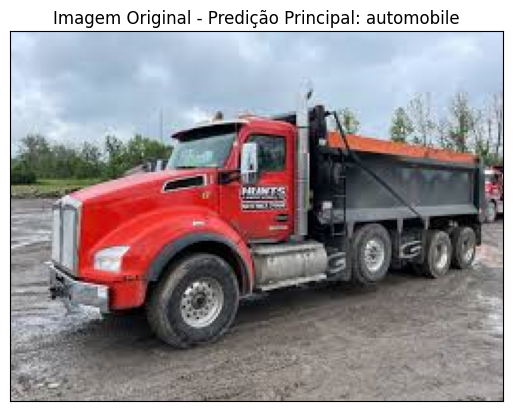

In [12]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

url = "https://raw.githubusercontent.com/FarzadNekouee/Keras-CIFAR10-CNN-Model/master/truck_sample.png"
resp = urllib.request.urlopen(url)
image = np.asarray(bytearray(resp.read()), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

original_image = image.copy()

image = cv2.resize(image, (32,32))
image = image.astype('float32')
image = (image-mean)/(std+1e-7)

input_image = image.reshape((1, 32, 32, 3))

predictions = model.predict(input_image)
main_prediction = predictions[-1]
predicted_class = main_prediction.argmax()
print('Predicted class (Main Exit): ', class_names[predicted_class])

plt.imshow(original_image)
plt.title(f'Imagem Original - Predição Principal: {class_names[predicted_class]}')
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


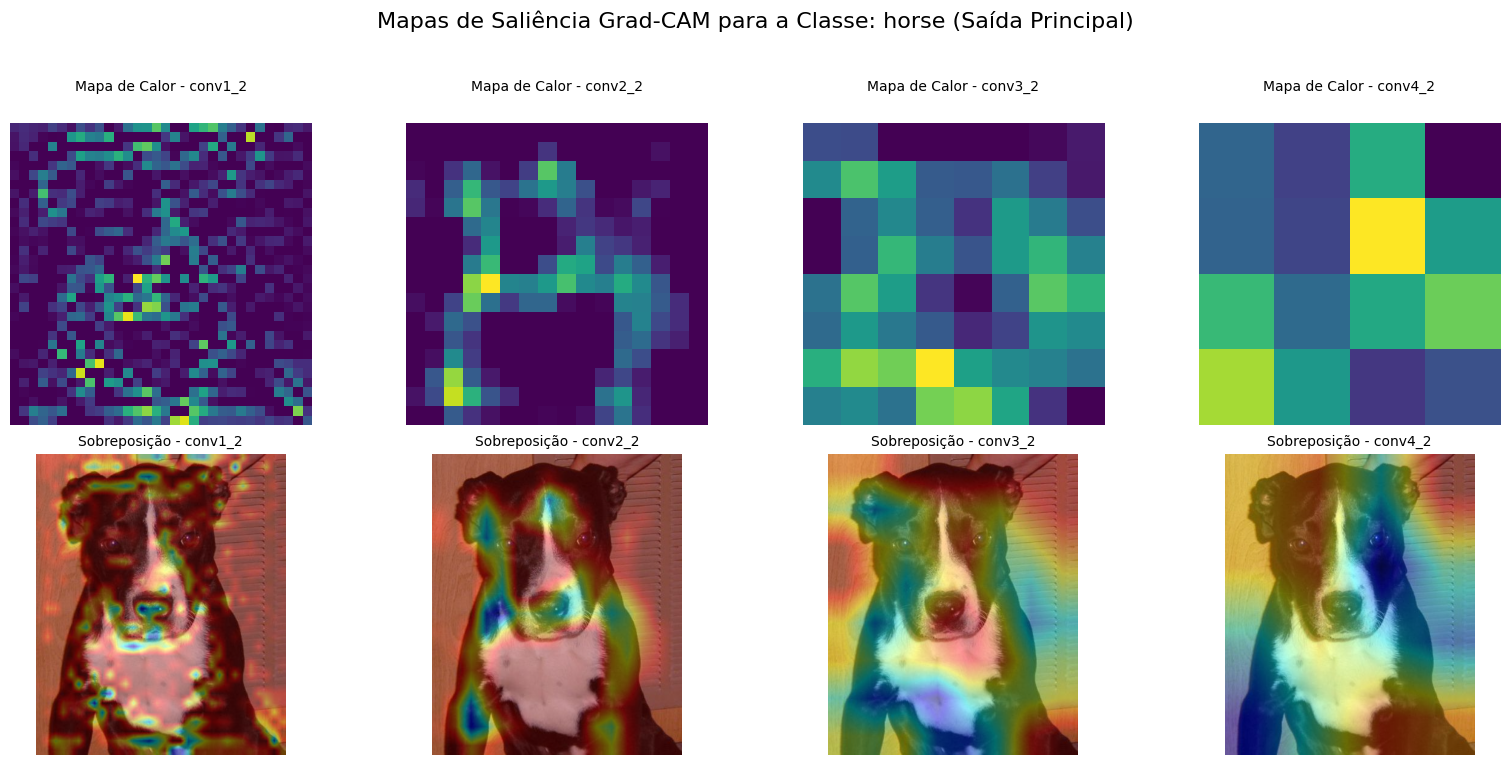

In [ ]:
def make_gradcam_heatmap_multi_output(img_array, model, last_conv_layer_name, output_index, pred_index=None):
   
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.outputs[output_index]]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(img)
    superimposed_img = cv2.addWeighted(superimposed_img, 1 - alpha, heatmap, alpha, 0)
    return superimposed_img, heatmap

raw_image_path = r"C:\Users\joaov_zm1q2wh\python\etsai\week_5\code\data\binary_classification\images\test\dog\dog.3234.jpg"

with open(raw_image_path, "rb") as f:
    image = np.asarray(bytearray(f.read()), dtype="uint8")
    
image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

original_image = image.copy()

image = cv2.resize(image, (32, 32))
# image = image.astype('float32') / 255.0
image = (image-mean)/(std+1e-7)
input_image = image.reshape((1, 32, 32, 3))

predictions = model.predict(input_image)
main_prediction = predictions[-1]
predicted_class = main_prediction.argmax()

conv_layer_names = [
    'conv1_2', 
    'conv2_2', 
    'conv3_2', 
    'conv4_2'
]

main_output_index = 3

num_layers = len(conv_layer_names)
fig, axes = plt.subplots(2, num_layers, figsize=(4 * num_layers, 8))
fig.suptitle(f'Mapas de Saliência Grad-CAM para a Classe: {class_names[predicted_class]} (Saída Principal)', fontsize=16)

for i, layer_name in enumerate(conv_layer_names):
    heatmap = make_gradcam_heatmap_multi_output(
        input_image, model, layer_name, main_output_index, predicted_class
    )
    
    axes[0, i].matshow(heatmap)
    axes[0, i].set_title(f'Mapa de Calor - {layer_name}', fontsize=10)
    axes[0, i].axis('off')
    
    superimposed_img, _ = display_gradcam(original_image, heatmap)
    
    axes[1, i].imshow(superimposed_img)
    axes[1, i].set_title(f'Sobreposição - {layer_name}', fontsize=10)
    axes[1, i].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Da última vez que fiz essa merda, na verdade foi um plot das Ativações dos FILTROS, onde eu mostrava a saída bruta de cada filtro em cada camada. O resultado são centenas de imagens em escala de cinza, uma para cada filtro. 

Dessa vez minha ideia foi fazer o Mapa de Saliência da IMAGEM usando o algoritmo Grad-CAM, que agrega a informação de todos os filtros de uma camada para gerar um único mapa de saliência, destacando as regiões da imagem de entrada que mais contribuíram para a predição da classe alvo. O resultado é um mapa de calor que é sobreposto à imagem original.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Saída 0 (output_exit_1): Classe automobile (Confiança: 0.9995)
Saída 1 (output_exit_2): Classe bird (Confiança: 0.8772)
Saída 2 (output_exit_3): Classe dog (Confiança: 0.4817)
Saída 3 (output_main): Classe bird (Confiança: 0.4451)


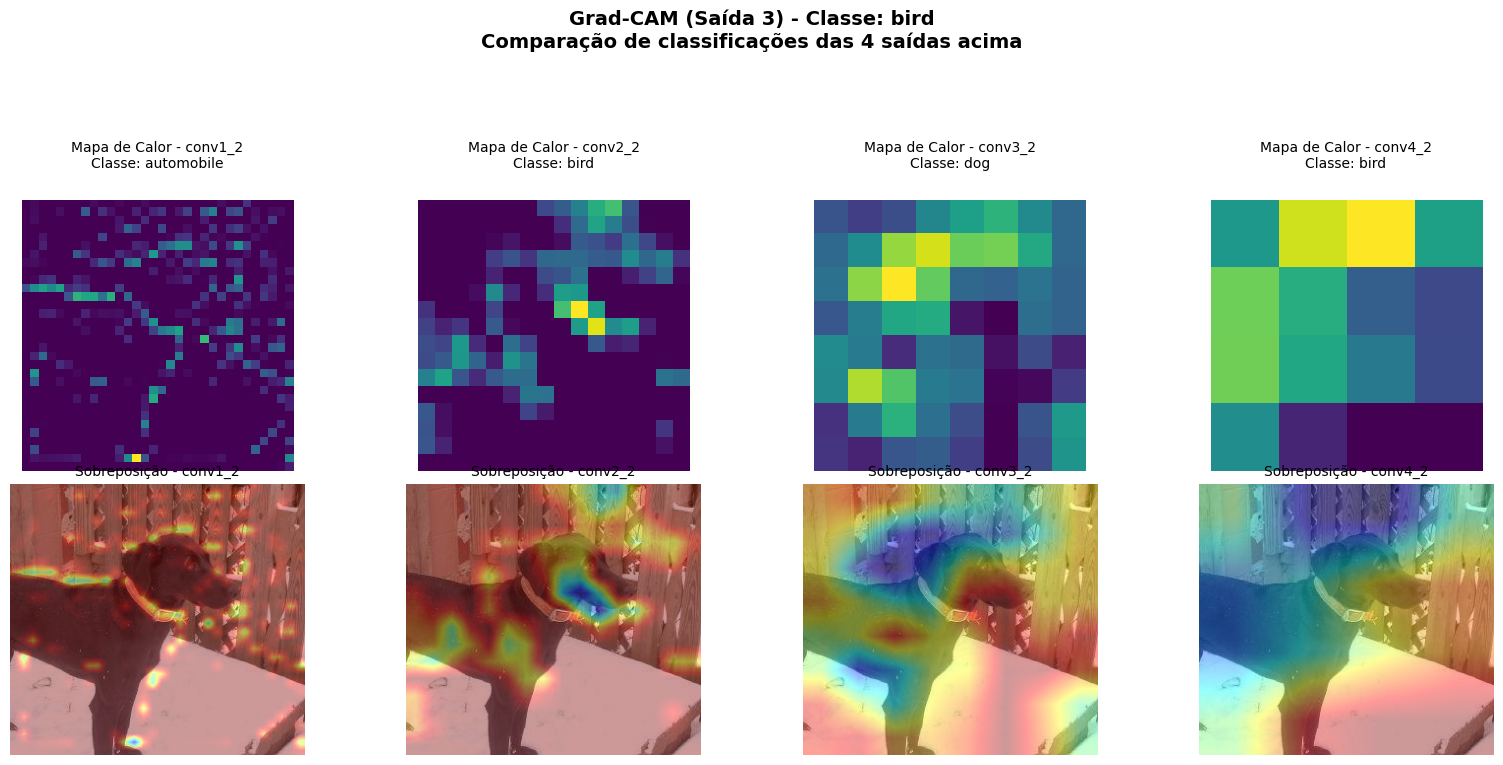

In [19]:
def make_gradcam_heatmap_multi_output(img_array, model, last_conv_layer_name, output_index, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.outputs[output_index]]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(img)
    superimposed_img = cv2.addWeighted(superimposed_img, 1 - alpha, heatmap, alpha, 0)
    return superimposed_img, heatmap

model_path = r"C:\Users\joaov_zm1q2wh\python\etsai\week_5\code\cifar10_cnn_model_early_exit.h5"
raw_image_path = r"C:\Users\joaov_zm1q2wh\python\etsai\week_5\code\data\binary_classification\images\test\dog\dog.7884.jpg"

model = load_model(model_path)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

with open(raw_image_path, "rb") as f:
    image = np.asarray(bytearray(f.read()), dtype="uint8")

image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

original_image = image.copy()

image = cv2.resize(image, (32, 32))
image = image.astype('float32') / 255.0
image = (image-mean)/(std+1e-7)
input_image = image.reshape((1, 32, 32, 3))
predictions = model.predict(input_image)
output_names = model.output_names

for i, p in enumerate(predictions):
    predicted_class_idx = np.argmax(p)
    predicted_class_name = class_names[predicted_class_idx]
    print(f"Saída {i} ({output_names[i]}): Classe {predicted_class_name} (Confiança: {np.max(p):.4f})")

main_output_index = 3

conv_layer_names = ['conv1_2', 'conv2_2', 'conv3_2', 'conv4_2']

num_layers = len(conv_layer_names)
fig, axes = plt.subplots(2, num_layers, figsize=(4 * num_layers, 8))

predicted_class = np.argmax(predictions[main_output_index])
predicted_class_name = class_names[predicted_class]

fig.suptitle(f"Grad-CAM (Saída {main_output_index}) - Classe: {predicted_class_name}\n"
             "Comparação de classificações das 4 saídas acima",
             fontsize=14, fontweight='bold')

for i, layer_name in enumerate(conv_layer_names):
    heatmap = make_gradcam_heatmap_multi_output(
        input_image, model, layer_name, main_output_index, predicted_class
    )

    layer_pred_class_idx = np.argmax(predictions[i])
    layer_pred_class_name = class_names[layer_pred_class_idx]

    axes[0, i].matshow(heatmap)
    axes[0, i].set_title(f"Mapa de Calor - {layer_name}\nClasse: {layer_pred_class_name}", fontsize=10)
    axes[0, i].axis('off')

    superimposed_img, _ = display_gradcam(original_image, heatmap)
    axes[1, i].imshow(superimposed_img)
    axes[1, i].set_title(f"Sobreposição - {layer_name}", fontsize=10)
    axes[1, i].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.show()